# Predicting Customer Churn in a Hotel Chain

The client of this study is the hotel chain "Like a Guest".

To attract customers, this hotel chain added the option to book a room without prepayment to its website. However, if a customer canceled a reservation, the company suffered losses. Hotel staff might, for example, overstock on groceries for the guest's arrival or simply be unable to find another customer.

To solve this problem, we need to develop a system that predicts cancellations. If the model predicts a cancellation, the customer is asked to pay a deposit. The deposit is 80% of the one-night room rate and one-time cleaning costs. The deposit will be debited from the customer's account if they cancel.

The proposed metric is the revenue generated after implementing the machine learning model.

## Data loading

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_score

In [2]:
# Disable the chain assignment warning
pd.options.mode.chained_assignment = None

The hotel data has already been split into training and test sets. Let's take a look.

In [3]:
# Read the csv files and display the dataset on the screen.
data_train = pd.read_csv('/datasets/hotel_train.csv')
data_test = pd.read_csv('/datasets/hotel_test.csv')

pd.set_option('display.max_columns', None)

display(data_train.head())
data_test.head()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,0.0,0.0,BB,GBR,Direct,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,PRT,Direct,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,0.0,0.0,FB,PRT,Direct,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,3


,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,0.0,0.0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7


In [4]:
pd.set_option('display.max_columns', 25)

In [5]:
# Let's take a look at the summary information for the datasets
display(data_train.info())
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

We have two datasets: one for training and one for testing. The training dataset contains 65,229 records and 25 features. The test dataset contains 32,412 records and 25 features. No missing values were observed.

The hotel_train and hotel_test tables contain the same columns:
* `id` — record number;
* `adults` — number of adult guests;
* `arrival_date_year` — year of arrival;
* `arrival_date_month` — month of arrival;
* `arrival_date_week_number` — week of arrival;
* `arrival_date_day_of_month` — day of arrival;
* `babies` — number of infants;
* `booking_changes` — number of booking details changes;
* `children` — number of children aged 3 to 14;
* `country` — guest citizenship;
* `customer_type` — customer type:
    * `Contract` — contract with a legal entity;
    * `Group` — group booking;
    * `Transient` — not related to a contract or group booking;
    * `Transient-party` — not related to a contract or group booking, but related to a Transient booking.
* `days_in_waiting_list` — number of days the order was waiting for confirmation;
* `distribution_channel` — order distribution channel;
* `is_canceled` — order cancellation (our target feature);
* `is_repeated_guest` — whether the guest is booking a room for the second time;
* `lead_time` — number of days between the booking date and the arrival date;
* `meal` — order options:
    * `SC` — no additional options;
    * `BB` — breakfast included;
    * `HB` — breakfast and lunch included;
    * `FB` — breakfast, lunch, and dinner included.
* `previous_bookings_not_canceled` — the number of confirmed bookings for the customer;
* `previous_cancellations` — the number of cancelled bookings for the customer;
* `required_car_parking_spaces` — whether a parking space is required;
* `reserved_room_type` — the type of reserved room;
* `stays_in_weekend_nights` — the number of weekend nights;
* `stays_in_week_nights` — the number of weekday nights;
* `total_nights` — the total number of nights;
* `total_of_special_requests` — the number of special requests.

## Preprocessing and exploratory data analysis

### Renaming features

In [6]:
# Fix the error in the is_cancelled attribute name
data_train = data_train.rename(columns={'is_canceled': 'is_cancelled'})
data_test = data_test.rename(columns={'is_canceled': 'is_cancelled'})

### Search for duplicates

Let's check the datasets for obvious duplicates.

In [7]:
display(data_train.duplicated().sum())
data_test.duplicated().sum()

0

0

There are no obvious duplicates.

### Research of numerical features

#### Descriptive statistics

In [8]:
data_train.describe()

,id,is_cancelled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000
mean,43544.069172,0.368609,96.337917,2015.719021,31.339772,15.847813,0.825185,2.224793,1.836576,0.074890,0.007236,0.027151,0.128915,0.107713,0.194269,3.334422,0.056647,0.512763,3.049978
std,25614.858971,0.482431,96.127545,0.449481,13.464024,8.748182,0.853477,1.354992,0.480245,0.334243,0.098790,0.162523,0.965326,1.326638,0.593838,18.239606,0.232094,0.752590,1.738108
min,0.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,19108.000000,0.000000,17.000000,2015.000000,21.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,40554.000000,0.000000,64.000000,2016.000000,34.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,67414.000000,1.000000,151.000000,2016.000000,42.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,84121.000000,1.000000,374.000000,2016.000000,53.000000,31.000000,4.000000,6.000000,4.000000,3.000000,10.000000,1.000000,26.000000,58.000000,17.000000,259.000000,3.000000,5.000000,10.000000


In [9]:
data_test.describe()

,id,is_cancelled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,32412.000000,32412.000000,32412.000000,32412.0,32412.000000,32412.000000,32412.000000,32412.00000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000
mean,60131.505183,0.388467,97.587869,2017.0,17.804054,15.656948,0.867888,2.34009,1.858602,0.083765,0.005523,0.031377,0.011601,0.171418,0.216741,0.262341,0.046248,0.657781,3.207979
std,29953.586177,0.487409,86.507146,0.0,9.177384,8.766429,0.853394,1.37517,0.489341,0.343470,0.075757,0.174338,0.180473,1.875170,0.640551,4.733027,0.219367,0.834341,1.738683
min,6086.000000,0.000000,0.000000,2017.0,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,45291.750000,0.000000,23.000000,2017.0,10.000000,8.000000,0.000000,1.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,53394.500000,0.000000,76.000000,2017.0,18.000000,15.500000,1.000000,2.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,89800.250000,1.000000,155.000000,2017.0,25.000000,23.000000,2.000000,3.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,97903.000000,1.000000,373.000000,2017.0,35.000000,31.000000,4.000000,6.00000,4.000000,3.000000,2.000000,1.000000,6.000000,72.000000,18.000000,223.000000,8.000000,5.000000,10.000000


Let's evaluate each numerical feature in our datasets using descriptive statistics:

1. `id` is the `id` of the hotel database record. We won't need it, so we'll delete it.
2. `is_cancelled` is an important Boolean attribute indicating whether the reservation was canceled. This attribute is also the target.
3. `lead_time` is a fairly large maximum value. Did someone book more than a year in advance? Looks like an outlier. We'll probably discard the top few percent from the dataset as outliers. On the other hand, some legal entities could have booked a room more than a year in advance.
4. `arrival_date_year` is the year of arrival. In the training dataset, we have 2015-2016. In the test dataset, it's 2017. It might be worth removing. These values could only confuse our models during training. Alternatively, we could make these values categorical.
5. `arrival_date_week_number` is the week of arrival. Essentially, we have a peculiar categorical variable here. We need to think about the best course of action here.
6. `arrival_date_day_of_month` - arrival day. Also, a categorical variable indicating the arrival day within a month.
7. `stays_in_weekend_nights`, `stays_in_week_nights` - number of nights on weekends and weekdays. There are no problems with the data.
8. `adults`, `children` - number of guests of different categories. No problems were noted in the descriptive statistics.
8. `babies` - there is a fairly large outlier. We'll check.
9. `is_repeated_guest` - Boolean feature. It could be useful for machine learning. No problems, we'll keep it.
10. `previous_cancellations` - number of canceled reservations. An important feature. There are no problems with the data.
11. `previous_bookings_not_canceled` - the number of confirmed bookings. 72 confirmed bookings at most - these are likely bookings from some organization. We don't consider them an outlier.
12. `booking_changes` - the number of booking changes. The maximum is 18, but why not?
13. `days_in_waiting_list` - "how many days the booking was waiting for confirmation." It's not entirely clear what this means. At most, 223 days, was the booking waiting for confirmation from the hotel? Or from the client? Looks like an outlier that should be discarded.
13. `required_car_parking_spaces` - the number of parking spaces. The maximum is 8. Why not? After all, the rooms could have been rented by a legal entity for a large number of employees at once. Let's check that.
14. `total_of_special_requests` - the number of special requests. Whatever that means. The maximum is 5. We'll leave it as is.
15. `total_nights` - the total number of nights. There are no data issues here.

##### required_car_parking_spaces

Let's check the number of parking spaces along with the number of adults.

In [10]:
display(data_train.required_car_parking_spaces.value_counts())
data_test.required_car_parking_spaces.value_counts()

0    61547
1     3670
2       11
3        1
Name: required_car_parking_spaces, dtype: int64

0    30935
1     1468
2        6
8        2
3        1
Name: required_car_parking_spaces, dtype: int64

In [11]:
display(data_train.query('required_car_parking_spaces == 3').adults)
display(data_test.query('required_car_parking_spaces == 8').adults)
data_test.query('required_car_parking_spaces == 3').adults

64080    1.0
Name: adults, dtype: float64

2549    2.0
2550    2.0
Name: adults, dtype: float64

25031    2.0
Name: adults, dtype: float64

Clearly an error. We will delete these records.

In [12]:
data_train = data_train.drop(index=[64080]).reset_index(drop=True)
data_test = data_test.drop(index=[2549, 2550, 25031]).reset_index(drop=True)

display(data_train.required_car_parking_spaces.value_counts())
data_test.required_car_parking_spaces.value_counts()

0    61547
1     3670
2       11
Name: required_car_parking_spaces, dtype: int64

0    30935
1     1468
2        6
Name: required_car_parking_spaces, dtype: int64

##### adults

Now let's check if there are any bookings without adults. If so, we'll consider them an anomaly and delete them.

In [13]:
display(data_train.query('adults == 0').id.count())
data_test.query('adults == 0').id.count()

166

69

In [14]:
data_train = data_train.query('adults != 0')
data_test = data_test.query('adults != 0')

display(data_train.query('adults == 0').id.count())
data_test.query('adults == 0').id.count()

0

0

##### babies

In [15]:
display(data_train.babies.value_counts())
data_test.babies.value_counts()

0.0     64613
1.0       444
2.0         3
9.0         1
10.0        1
Name: babies, dtype: int64

0.0    32165
1.0      171
2.0        4
Name: babies, dtype: int64

The training set contains two records with 9 and 10 infants. We have a maximum of 4 adults in the dataset. This is an anomaly; we'll remove the records with 9 and 10 infants.

In [16]:
data_train = data_train.query('babies < 9')
data_train.babies.value_counts()

0.0    64613
1.0      444
2.0        3
Name: babies, dtype: int64

#### Correlation research

Now let's look at the correlation tables

In [17]:
data_train.corr()

,id,is_cancelled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
id,1.000000,-0.241241,0.004529,0.249033,0.069610,0.008732,-0.094532,-0.157889,0.006594,0.001936,-0.028470,0.002935,-0.003709,0.016699,-0.002945,-0.023327,-0.114907,0.123463,-0.169504
is_cancelled,-0.241241,1.000000,0.328589,-0.030691,0.012768,-0.001825,-0.013850,0.010420,0.044399,-0.017196,-0.032445,-0.040305,0.153125,-0.045639,-0.142723,0.075857,-0.186855,-0.257144,0.001326
lead_time,0.004529,0.328589,1.000000,-0.023274,0.091303,-0.010770,0.046920,0.172660,0.121804,-0.058760,-0.026173,-0.089441,0.142552,-0.061735,-0.007377,0.209902,-0.116883,-0.147972,0.157648
arrival_date_year,0.249033,-0.030691,-0.023274,1.000000,-0.388259,0.009666,-0.006701,0.013444,0.034142,0.048739,-0.006688,-0.005621,-0.133987,0.040279,0.040970,0.027455,0.014982,0.089268,0.007192
arrival_date_week_number,0.069610,0.012768,0.091303,-0.388259,1.000000,0.048057,0.034088,0.032473,0.004840,-0.005873,0.006797,-0.013663,0.006869,-0.011970,0.011738,-0.053109,-0.007890,0.076323,0.042051
arrival_date_day_of_month,0.008732,-0.001825,-0.010770,0.009666,0.048057,1.000000,-0.002250,0.003509,0.007526,0.017100,0.001427,-0.010720,-0.032032,-0.000967,0.022663,0.017153,0.004204,0.005445,0.001631
stays_in_weekend_nights,-0.094532,-0.013850,0.046920,-0.006701,0.034088,-0.002250,1.000000,0.197475,0.121046,0.025612,0.022206,-0.082025,-0.008677,-0.025560,0.022586,-0.065175,-0.015787,0.083488,0.644861
stays_in_week_nights,-0.157889,0.010420,0.172660,0.013444,0.032473,0.003509,0.197475,1.000000,0.123807,0.023525,0.023524,-0.094674,-0.006067,-0.049211,0.060859,0.036142,-0.026625,0.090502,0.876593
adults,0.006594,0.044399,0.121804,0.034142,0.004840,0.007526,0.121046,0.123807,1.000000,0.051848,0.027499,-0.161427,0.001870,-0.118341,-0.052453,-0.015562,0.012027,0.180766,0.155948
children,0.001936,-0.017196,-0.058760,0.048739,-0.005873,0.017100,0.025612,0.023525,0.051848,1.000000,0.021448,-0.025487,-0.026749,-0.015340,0.051918,-0.037703,0.053163,0.109980,0.030914


In [18]:
data_test.corr()

,id,is_cancelled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
id,1.000000,-0.459661,-0.047087,NaN,0.169934,0.017909,-0.064669,-0.117771,0.036615,-0.019749,-0.011933,-0.099075,-0.018055,-0.035776,0.023190,-0.026178,-0.131125,0.131527,-0.124882
is_cancelled,-0.459661,1.000000,0.238366,NaN,0.037520,-0.008846,-0.002126,0.047103,0.079499,0.010609,-0.038916,-0.125447,-0.032898,-0.065367,-0.137237,0.019225,-0.173647,-0.218428,0.036208
lead_time,-0.047087,0.238366,1.000000,NaN,0.345032,0.033442,0.163539,0.290248,0.195640,0.043504,0.003052,-0.169408,-0.058774,-0.089583,0.034599,0.066031,-0.100476,0.028797,0.309816
arrival_date_year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
arrival_date_week_number,0.169934,0.037520,0.345032,NaN,1.000000,0.124338,0.064400,0.083359,0.121518,0.033759,-0.003465,-0.062204,-0.007960,-0.011310,0.020382,-0.012317,-0.038266,0.063268,0.097535
arrival_date_day_of_month,0.017909,-0.008846,0.033442,NaN,0.124338,1.000000,0.002510,-0.029135,-0.019092,0.005790,-0.003798,0.005309,0.002686,0.008123,-0.001709,-0.005966,0.011093,-0.007500,-0.021809
stays_in_weekend_nights,-0.064669,-0.002126,0.163539,NaN,0.064400,0.002510,1.000000,0.172111,0.105601,0.047757,0.021363,-0.090261,-0.035789,-0.052821,0.013621,0.009829,-0.032013,0.042789,0.626962
stays_in_week_nights,-0.117771,0.047103,0.290248,NaN,0.083359,-0.029135,0.172111,1.000000,0.147270,0.034744,0.030645,-0.115359,-0.036384,-0.057997,0.043992,0.017325,-0.051478,0.035201,0.875331
adults,0.036615,0.079499,0.195640,NaN,0.121518,-0.019092,0.105601,0.147270,1.000000,0.037733,0.019109,-0.206037,-0.103834,-0.140540,-0.058978,-0.004690,-0.017381,0.128560,0.168303
children,-0.019749,0.010609,0.043504,NaN,0.033759,0.005790,0.047757,0.034744,0.037733,1.000000,0.027723,-0.029915,-0.015437,-0.019829,0.038598,-0.013286,0.032557,0.063171,0.050919


Observed features: the target feature `is_cancelled` is negatively correlated with `id`. Order `id`s are the numbers assigned to new records. This means that the `id` increases with each order. This negative correlation suggests that the number of booking cancellations is increasing over time. This is most noticeable in the test set, which contains data for 2017. The training set contains data for 2015-2016.

There is a weak positive correlation between `lead_time` and `is_cancelled`. This may indicate that the likelihood of booking cancellation increases if the order is placed well in advance.

In the `data_test` dataset, the correlation between `arrival_date_week_number` and `lead_time` may be explained by the fact that the data in this dataset is only available for one year. It is difficult to determine the true reasons for this correlation. This may be due to database features and how reservations are processed if the user books a room for the following year.

There is also a clear correlation between `total_nights`, `stays_in_weekend_nights`, and `stays_in_week_nights`.

No significant correlation is observed for the other parameters.

### Research of string features

In [19]:
data_train.select_dtypes(include=['object']).head()

,arrival_date_month,meal,country,distribution_channel,reserved_room_type,customer_type
0,July,BB,GBR,Direct,A,Transient
1,July,BB,GBR,TA/TO,A,Transient
2,July,BB,PRT,Direct,C,Transient
3,July,FB,PRT,Direct,C,Transient
4,July,BB,PRT,TA/TO,A,Transient


In [20]:
data_test.select_dtypes(include=['object']).head()

,arrival_date_month,meal,country,distribution_channel,reserved_room_type,customer_type
0,January,BB,PRT,TA/TO,A,Transient
1,January,BB,AUT,TA/TO,A,Transient
2,January,BB,AUT,TA/TO,A,Transient
3,January,BB,PRT,TA/TO,A,Transient
4,January,BB,BEL,TA/TO,A,Transient


In total, we have six features with string values. Let's take a closer look at them.

#### arrival_date_month

In [21]:
display(data_train.arrival_date_month.value_counts())
data_test.arrival_date_month.value_counts()

October      9238
September    8771
August       6647
November     5750
July         5701
December     5477
April        4795
May          4667
June         4651
March        4138
February     3344
January      1881
Name: arrival_date_month, dtype: int64

May         5253
April       4864
June        4574
March       4266
July        3610
February    3538
January     3142
August      3093
Name: arrival_date_month, dtype: int64

No anomalies were observed. The only notable thing is that the test sample does not include data for autumn.

#### meal

In [22]:
display(data_train.meal.value_counts())
data_test.meal.value_counts()

BB           51543
HB            7289
SC            5262
SC             515
FB             451
Name: meal, dtype: int64

BB           24624
SC            5026
HB            2396
SC             258
FB              36
Name: meal, dtype: int64

There's a duplicate of the "SC" objects, likely due to an extra space. We'll fix that.

In [23]:
data_train.meal = data_train.meal.str.strip()
data_test.meal = data_test.meal.str.strip()

In [24]:
display(data_train.meal.value_counts())
data_test.meal.value_counts()

BB    51543
HB     7289
SC     5777
FB      451
Name: meal, dtype: int64

BB    24624
SC     5284
HB     2396
FB       36
Name: meal, dtype: int64

No further anomalies were observed.

#### country

In [25]:
display(data_train.country.value_counts())
data_test.country.value_counts()

PRT    28790
FRA     5958
GBR     5095
ESP     4887
DEU     3879
       ...  
BHR        1
PRY        1
IMN        1
MMR        1
BEN        1
Name: country, Length: 155, dtype: int64

PRT    9881
GBR    3924
FRA    3468
DEU    2374
ESP    1929
       ... 
STP       1
PRI       1
NPL       1
MYT       1
SDN       1
Name: country, Length: 143, dtype: int64

There are more than 140 different objects in this feature. Anomalies are not excluded, but no obvious problems have been noticed.

#### distribution_channel

In [26]:
display(data_train.distribution_channel.value_counts())
data_test.distribution_channel.value_counts()

TA/TO        54309
Direct        6831
Corporate     3821
GDS             99
Name: distribution_channel, dtype: int64

TA/TO        27022
Direct        3634
Corporate     1599
GDS             85
Name: distribution_channel, dtype: int64

No anomalies were observed.

####  reserved_room_type

In [27]:
display(data_train.reserved_room_type.value_counts())
data_test.reserved_room_type.value_counts()

A                   50486
D                    9384
E                    2445
F                    1211
B                     714
G                     592
C                     228
Name: reserved_room_type, dtype: int64

A                   23459
D                    6122
E                    1641
F                     503
G                     278
C                     201
B                     136
Name: reserved_room_type, dtype: int64

There may be extra spaces because the object count values are too far to the right.

In [28]:
data_train.reserved_room_type = data_train.reserved_room_type.str.strip()
data_test.reserved_room_type = data_test.reserved_room_type.str.strip()

In [29]:
display(data_train.reserved_room_type.value_counts())
data_test.reserved_room_type.value_counts()

A    50486
D     9384
E     2445
F     1211
B      714
G      592
C      228
Name: reserved_room_type, dtype: int64

A    23459
D     6122
E     1641
F      503
G      278
C      201
B      136
Name: reserved_room_type, dtype: int64

Yes, there were indeed extra spaces. No other anomalies were noticed.

#### customer_type

In [30]:
display(data_train.customer_type.value_counts())
data_test.customer_type.value_counts()

Transient          45400
Transient-Party    16629
Contract            2745
Group                286
Name: customer_type, dtype: int64

Transient          27401
Transient-Party     4415
Contract             359
Group                165
Name: customer_type, dtype: int64

No anomalies were observed.

### Processing cyclic features

Let's process cyclical features. Such as:
* `arrival_date_week_number`
* `arrival_date_day_of_month`

We'll convert them to polar coordinates by plotting the values on a circle and calculating the sine and cosine for each value. This way, we can tell the machine learning model that the maximum and minimum values are close to each other. For example, like 23 hours and 0 hours.

####  arrival_date_week_number

In [31]:
# Check the unique values of this feature in the datasets
display(data_train.arrival_date_week_number.unique())
data_test.arrival_date_week_number.unique()

array([27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53,  1,  2,  3,  4,  5,  6,  7,
        8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
       25, 26])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35])

Let's assume that we have 53 weeks in a year. Let's calculate additional characteristics.

In [32]:
data_train['arrival_date_week_sin'] = np.sin(data_train.arrival_date_week_number*(2.*np.pi/53))
data_train['arrival_date_week_cos'] = np.cos(data_train.arrival_date_week_number*(2.*np.pi/53))

data_test['arrival_date_week_sin'] = np.sin(data_test.arrival_date_week_number*(2.*np.pi/53))
data_test['arrival_date_week_cos'] = np.cos(data_test.arrival_date_week_number*(2.*np.pi/53))

display(data_train.head())
data_test.head()

,id,is_cancelled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,arrival_date_week_sin,arrival_date_week_cos
0,0,0,7.0,2015,July,27,1,0,1,1.0,0.0,0.0,...,0,0,0,A,0,0,Transient,0,0,1,-0.059241,-0.998244
1,1,0,14.0,2015,July,27,1,0,2,2.0,0.0,0.0,...,0,0,0,A,0,0,Transient,0,1,2,-0.059241,-0.998244
2,2,0,0.0,2015,July,27,1,0,2,2.0,0.0,0.0,...,0,0,0,C,0,0,Transient,0,0,2,-0.059241,-0.998244
3,3,0,9.0,2015,July,27,1,0,2,2.0,0.0,0.0,...,0,0,0,C,0,0,Transient,0,1,2,-0.059241,-0.998244
4,4,1,85.0,2015,July,27,1,0,3,2.0,0.0,0.0,...,0,0,0,A,0,0,Transient,0,1,3,-0.059241,-0.998244


,id,is_cancelled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,arrival_date_week_sin,arrival_date_week_cos
0,6086,1,74.0,2017,January,1,1,1,0,2.0,0.0,0.0,...,0,0,0,A,0,0,Transient,0,0,1,0.118273,0.992981
1,6087,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,...,0,0,0,A,0,0,Transient,0,1,4,0.118273,0.992981
2,6088,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,...,0,0,0,A,0,0,Transient,0,1,4,0.118273,0.992981
3,6089,1,71.0,2017,January,1,1,2,2,1.0,0.0,0.0,...,0,0,0,A,0,0,Transient,0,1,4,0.118273,0.992981
4,6090,1,172.0,2017,January,1,1,2,5,2.0,0.0,0.0,...,0,0,0,A,0,0,Transient,0,0,7,0.118273,0.992981


#### arrival_date_day_of_month

In [33]:
# Look at the unique values of this attribute in the datasets
display(data_train.arrival_date_day_of_month.unique())
data_test.arrival_date_day_of_month.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 11, 12, 13, 14, 16, 17, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 10, 15, 18])

Let's indicate that the number of days in a month is 31. Calculate additional features.

In [34]:
data_train['arrival_date_day_of_month_sin'] = np.sin(data_train.arrival_date_day_of_month*(2.*np.pi/53))
data_train['arrival_date_day_of_month_cos'] = np.cos(data_train.arrival_date_day_of_month*(2.*np.pi/53))

data_test['arrival_date_day_of_month_sin'] = np.sin(data_test.arrival_date_day_of_month*(2.*np.pi/53))
data_test['arrival_date_day_of_month_cos'] = np.cos(data_test.arrival_date_day_of_month*(2.*np.pi/53))

display(data_train.head())
data_test.head()

,id,is_cancelled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,arrival_date_week_sin,arrival_date_week_cos,arrival_date_day_of_month_sin,arrival_date_day_of_month_cos
0,0,0,7.0,2015,July,27,1,0,1,1.0,0.0,0.0,...,0,A,0,0,Transient,0,0,1,-0.059241,-0.998244,0.118273,0.992981
1,1,0,14.0,2015,July,27,1,0,2,2.0,0.0,0.0,...,0,A,0,0,Transient,0,1,2,-0.059241,-0.998244,0.118273,0.992981
2,2,0,0.0,2015,July,27,1,0,2,2.0,0.0,0.0,...,0,C,0,0,Transient,0,0,2,-0.059241,-0.998244,0.118273,0.992981
3,3,0,9.0,2015,July,27,1,0,2,2.0,0.0,0.0,...,0,C,0,0,Transient,0,1,2,-0.059241,-0.998244,0.118273,0.992981
4,4,1,85.0,2015,July,27,1,0,3,2.0,0.0,0.0,...,0,A,0,0,Transient,0,1,3,-0.059241,-0.998244,0.118273,0.992981


,id,is_cancelled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,arrival_date_week_sin,arrival_date_week_cos,arrival_date_day_of_month_sin,arrival_date_day_of_month_cos
0,6086,1,74.0,2017,January,1,1,1,0,2.0,0.0,0.0,...,0,A,0,0,Transient,0,0,1,0.118273,0.992981,0.118273,0.992981
1,6087,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,...,0,A,0,0,Transient,0,1,4,0.118273,0.992981,0.118273,0.992981
2,6088,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,...,0,A,0,0,Transient,0,1,4,0.118273,0.992981,0.118273,0.992981
3,6089,1,71.0,2017,January,1,1,2,2,1.0,0.0,0.0,...,0,A,0,0,Transient,0,1,4,0.118273,0.992981,0.118273,0.992981
4,6090,1,172.0,2017,January,1,1,2,5,2.0,0.0,0.0,...,0,A,0,0,Transient,0,0,7,0.118273,0.992981,0.118273,0.992981


### Adding features

It's known that seasonal coefficients vary depending on the season. Let's add the `arrival_season` attribute based on the month in which the check-in occurred.

In [35]:
# Check the unique values of the arrival_date_month attribute
display(data_train.arrival_date_month.unique())
data_test.arrival_date_month.unique()

array(['July', 'August', 'September', 'October', 'November', 'December',
       'January', 'February', 'March', 'April', 'May', 'June'],
      dtype=object)

array(['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August'], dtype=object)

It's worth noting that our test dataset doesn't include September, October, November, and December. We'll write a function that takes this into account.

In [36]:
WINTER = ['December', 'January', 'February']
SPRING = ['March', 'April', 'May']
SUMMER = ['June', 'July', 'August']

def set_season(row):
    if row.arrival_date_month in WINTER:
        return 'Winter'
    elif row.arrival_date_month in SPRING:
        return 'Spring'
    elif row.arrival_date_month in SUMMER:
        return 'Summer'
    else:
        return 'Autumn'

In [37]:
data_train['arrival_season'] = data_train.apply(set_season, axis=1)
data_test['arrival_season'] = data_test.apply(set_season, axis=1)

display(data_train.head())
data_test.head()

,id,is_cancelled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,arrival_date_week_sin,arrival_date_week_cos,arrival_date_day_of_month_sin,arrival_date_day_of_month_cos,arrival_season
0,0,0,7.0,2015,July,27,1,0,1,1.0,0.0,0.0,...,A,0,0,Transient,0,0,1,-0.059241,-0.998244,0.118273,0.992981,Summer
1,1,0,14.0,2015,July,27,1,0,2,2.0,0.0,0.0,...,A,0,0,Transient,0,1,2,-0.059241,-0.998244,0.118273,0.992981,Summer
2,2,0,0.0,2015,July,27,1,0,2,2.0,0.0,0.0,...,C,0,0,Transient,0,0,2,-0.059241,-0.998244,0.118273,0.992981,Summer
3,3,0,9.0,2015,July,27,1,0,2,2.0,0.0,0.0,...,C,0,0,Transient,0,1,2,-0.059241,-0.998244,0.118273,0.992981,Summer
4,4,1,85.0,2015,July,27,1,0,3,2.0,0.0,0.0,...,A,0,0,Transient,0,1,3,-0.059241,-0.998244,0.118273,0.992981,Summer


,id,is_cancelled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,arrival_date_week_sin,arrival_date_week_cos,arrival_date_day_of_month_sin,arrival_date_day_of_month_cos,arrival_season
0,6086,1,74.0,2017,January,1,1,1,0,2.0,0.0,0.0,...,A,0,0,Transient,0,0,1,0.118273,0.992981,0.118273,0.992981,Winter
1,6087,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,...,A,0,0,Transient,0,1,4,0.118273,0.992981,0.118273,0.992981,Winter
2,6088,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,...,A,0,0,Transient,0,1,4,0.118273,0.992981,0.118273,0.992981,Winter
3,6089,1,71.0,2017,January,1,1,2,2,1.0,0.0,0.0,...,A,0,0,Transient,0,1,4,0.118273,0.992981,0.118273,0.992981,Winter
4,6090,1,172.0,2017,January,1,1,2,5,2.0,0.0,0.0,...,A,0,0,Transient,0,0,7,0.118273,0.992981,0.118273,0.992981,Winter


### Removing features

Let's remove the 'id' feature. It will likely only confuse the model.

Also we'll remove 'arrival_date_year'. Our model won't need it in the future, as it won't make predictions based on data from previous years.

We'll remove 'total_nights' because we have two features whose sum can be used to calculate its value.

And we'll remove 'arrival_date_week_number' and 'arrival_date_day_of_month' – we recoded these features in Section 2.4 because they are cyclic.

In [38]:
features_to_drop = ['id',
                    'arrival_date_year',
                    'arrival_date_week_number', 
                    'arrival_date_day_of_month', 
                    'total_nights']

data_train = data_train.drop(features_to_drop, axis=1)
data_test = data_test.drop(features_to_drop, axis=1)

display(data_train.info())
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65060 entries, 0 to 65227
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_cancelled                    65060 non-null  int64  
 1   lead_time                       65060 non-null  float64
 2   arrival_date_month              65060 non-null  object 
 3   stays_in_weekend_nights         65060 non-null  int64  
 4   stays_in_week_nights            65060 non-null  int64  
 5   adults                          65060 non-null  float64
 6   children                        65060 non-null  float64
 7   babies                          65060 non-null  float64
 8   meal                            65060 non-null  object 
 9   country                         65060 non-null  object 
 10  distribution_channel            65060 non-null  object 
 11  is_repeated_guest               65060 non-null  int64  
 12  previous_cancellations          

None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32340 entries, 0 to 32408
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_cancelled                    32340 non-null  int64  
 1   lead_time                       32340 non-null  float64
 2   arrival_date_month              32340 non-null  object 
 3   stays_in_weekend_nights         32340 non-null  int64  
 4   stays_in_week_nights            32340 non-null  int64  
 5   adults                          32340 non-null  float64
 6   children                        32340 non-null  float64
 7   babies                          32340 non-null  float64
 8   meal                            32340 non-null  object 
 9   country                         32340 non-null  object 
 10  distribution_channel            32340 non-null  object 
 11  is_repeated_guest               32340 non-null  int64  
 12  previous_cancellations          

Let's check the datasets again for duplicates.

In [39]:
display(data_train.duplicated().sum())
data_test.duplicated().sum()

21385

7713

Quite a large number of duplicates were detected. Let's remove them.

In [40]:
data_train = data_train.drop_duplicates().reset_index(drop=True)
data_test = data_test.drop_duplicates().reset_index(drop=True)

display(data_train.duplicated().sum())
data_test.duplicated().sum()

0

0

### Removal of part of the outliers

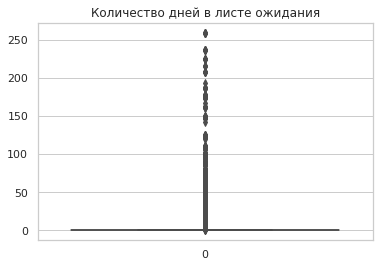

In [41]:
# Check the boxplot for the data_train.days_in_waiting_list feature
sns.set_theme(style="whitegrid")
sns.boxplot(data=data_train.days_in_waiting_list).set_title('Number of days on the waiting list');

You can see that the outliers extend significantly beyond the main set of values. We'll discard 1% of the maximum values for this feature to reduce the impact of outliers on model training.

In [42]:
# The size of the datasets before the changes
display(data_train.shape)
display(data_test.shape)

(43675, 25)

(24627, 25)

In [43]:
# Find the 0.99 quantile for each dataset based on the days_in_waiting_list feature
# Leave values below this quantile in the datasets
discarded_train = data_train.days_in_waiting_list.quantile(0.99)
discarded_test = data_test.days_in_waiting_list.quantile(0.99)

data_train = data_train.query('days_in_waiting_list <= @discarded_train')
data_test = data_test.query('days_in_waiting_list <= @discarded_test')

display(data_train.shape)
display(data_test.shape)

(43253, 25)

(24453, 25)

### Target feature extraction

In [44]:
# Select the target feature from each sample
target_train = data_train['is_cancelled'].copy()
target_test = data_test['is_cancelled'].copy()

features_train = data_train.copy().drop('is_cancelled', axis=1).reset_index(drop=True)
features_test = data_test.copy().drop('is_cancelled', axis=1).reset_index(drop=True)

### Feature scaling

In [45]:
# Scale the features in the samples
numeric = [
    'lead_time', 
    'stays_in_weekend_nights', 
    'stays_in_week_nights', 
    'adults', 
    'children', 
    'babies',
    'previous_cancellations',
    'previous_bookings_not_canceled',
    'booking_changes',
    'days_in_waiting_list',
    'required_car_parking_spaces',
    'total_of_special_requests'
]

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

# Display the scaled training sample on the screen
features_train.head()

,lead_time,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,arrival_date_week_sin,arrival_date_week_cos,arrival_date_day_of_month_sin,arrival_date_day_of_month_cos,arrival_season
0,-0.818727,July,-1.037204,-0.898748,-1.757824,-0.266169,-0.101502,BB,GBR,Direct,0,-0.089968,-0.098028,A,-0.363695,-0.032253,Transient,-0.300585,-0.839560,-0.059241,-0.998244,0.118273,0.992981,Summer
1,-0.722707,July,-1.037204,-0.213039,0.273954,-0.266169,-0.101502,BB,GBR,TA/TO,0,-0.089968,-0.098028,A,-0.363695,-0.032253,Transient,-0.300585,0.404351,-0.059241,-0.998244,0.118273,0.992981,Summer
2,-0.914746,July,-1.037204,-0.213039,0.273954,-0.266169,-0.101502,BB,PRT,Direct,0,-0.089968,-0.098028,C,-0.363695,-0.032253,Transient,-0.300585,-0.839560,-0.059241,-0.998244,0.118273,0.992981,Summer
3,-0.791292,July,-1.037204,-0.213039,0.273954,-0.266169,-0.101502,FB,PRT,Direct,0,-0.089968,-0.098028,C,-0.363695,-0.032253,Transient,-0.300585,0.404351,-0.059241,-0.998244,0.118273,0.992981,Summer
4,0.251207,July,-1.037204,0.472671,0.273954,-0.266169,-0.101502,BB,PRT,TA/TO,0,-0.089968,-0.098028,A,-0.363695,-0.032253,Transient,-0.300585,0.404351,-0.059241,-0.998244,0.118273,0.992981,Summer


### Encoding of features

#### One-Hot Encoding 

For logistic regression, we'll encode categorical features using One-Hot Encoding.
In our case, using the standard pandas OHE encoder isn't the best idea: we have pre-split training and test sets. The test set contains fewer features in the `country` and `arrival_date_month` features. This will ultimately result in the test set having fewer features after encoding. This, in turn, could lead to incorrect performance of the trained model.

For encoding, we'll use the OneHotEncoder from the scikit-learn library.

In [46]:
# Re-encode categorical features using one-hot encoding
# For the encoder from the scikit-learn library, it is necessary to extract string categorical features separately
ohe = OneHotEncoder(handle_unknown='ignore')

features_object_train = features_train.select_dtypes('object')
features_object_test = features_test.select_dtypes('object')

ohe.fit(features_object_train)

features_object_train_ohe = ohe.transform(features_object_train)
features_object_test_ohe = ohe.transform(features_object_test)

codes_train = features_object_train_ohe.toarray()
codes_test = features_object_test_ohe.toarray()

feature_names = ohe.get_feature_names(list(features_train.select_dtypes('object').columns))

features_ohe_train = pd.concat([features_train.select_dtypes(exclude='object'), 
                                pd.DataFrame(codes_train, columns=feature_names).astype(int)], axis=1)
features_ohe_test = pd.concat([features_test.select_dtypes(exclude='object'), 
                                pd.DataFrame(codes_test, columns=feature_names).astype(int)], axis=1)

display(features_ohe_train.head())
features_ohe_test.head()

,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,...,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,arrival_season_Autumn,arrival_season_Spring,arrival_season_Summer,arrival_season_Winter
0,-0.818727,-1.037204,-0.898748,-1.757824,-0.266169,-0.101502,0,-0.089968,-0.098028,-0.363695,-0.032253,-0.300585,...,0,0,0,0,0,0,1,0,0,0,1,0
1,-0.722707,-1.037204,-0.213039,0.273954,-0.266169,-0.101502,0,-0.089968,-0.098028,-0.363695,-0.032253,-0.300585,...,0,0,0,0,0,0,1,0,0,0,1,0
2,-0.914746,-1.037204,-0.213039,0.273954,-0.266169,-0.101502,0,-0.089968,-0.098028,-0.363695,-0.032253,-0.300585,...,0,0,0,0,0,0,1,0,0,0,1,0
3,-0.791292,-1.037204,-0.213039,0.273954,-0.266169,-0.101502,0,-0.089968,-0.098028,-0.363695,-0.032253,-0.300585,...,0,0,0,0,0,0,1,0,0,0,1,0
4,0.251207,-1.037204,0.472671,0.273954,-0.266169,-0.101502,0,-0.089968,-0.098028,-0.363695,-0.032253,-0.300585,...,0,0,0,0,0,0,1,0,0,0,1,0


,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,...,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,arrival_season_Autumn,arrival_season_Spring,arrival_season_Summer,arrival_season_Winter
0,0.100319,0.115147,-1.584457,0.273954,-0.266169,-0.101502,0,-0.089968,-0.098028,-0.363695,-0.032253,-0.300585,...,0,0,0,0,0,0,1,0,0,0,0,1
1,-0.064286,1.267499,-0.213039,0.273954,-0.266169,-0.101502,0,-0.089968,-0.098028,-0.363695,-0.032253,-0.300585,...,0,0,0,0,0,0,1,0,0,0,0,1
2,0.059168,1.267499,-0.213039,-1.757824,-0.266169,-0.101502,0,-0.089968,-0.098028,-0.363695,-0.032253,-0.300585,...,0,0,0,0,0,0,1,0,0,0,0,1
3,1.444595,1.267499,1.844089,0.273954,-0.266169,-0.101502,0,-0.089968,-0.098028,-0.363695,-0.032253,-0.300585,...,0,0,0,0,0,0,1,0,0,0,0,1
4,-0.201457,1.267499,1.844089,-1.757824,-0.266169,-0.101502,0,-0.089968,-0.098028,-0.363695,-0.032253,-0.300585,...,0,0,0,0,0,0,1,0,0,0,0,1


#### Ordinal Encoding

For the random forest, we use ordinal encoding. This will reduce model training time without sacrificing quality.

In [47]:
ore = OrdinalEncoder(handle_unknown='ignore')

features_object_train = features_train.select_dtypes('object')
features_object_test = features_test.select_dtypes('object')

ore.fit(features_object_train)

features_object_train_ore = ore.transform(features_object_train)
features_object_test_ore = ore.transform(features_object_test)

features_ore_train = pd.concat([features_train.select_dtypes(exclude='object'), 
                                pd.DataFrame(features_object_train_ore, columns=features_object_train.columns).astype(int)], axis=1)
features_ore_test = pd.concat([features_test.select_dtypes(exclude='object'), 
                                pd.DataFrame(features_object_test_ore, columns=features_object_train.columns).astype(int)], axis=1)

display(features_ore_train.head())
features_ore_test.head()

,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,arrival_date_week_sin,arrival_date_week_cos,arrival_date_day_of_month_sin,arrival_date_day_of_month_cos,arrival_date_month,meal,country,distribution_channel,reserved_room_type,customer_type,arrival_season
0,-0.818727,-1.037204,-0.898748,-1.757824,-0.266169,-0.101502,0,-0.089968,-0.098028,-0.363695,-0.032253,-0.300585,-0.839560,-0.059241,-0.998244,0.118273,0.992981,5,0,50,1,0,2,2
1,-0.722707,-1.037204,-0.213039,0.273954,-0.266169,-0.101502,0,-0.089968,-0.098028,-0.363695,-0.032253,-0.300585,0.404351,-0.059241,-0.998244,0.118273,0.992981,5,0,50,3,0,2,2
2,-0.914746,-1.037204,-0.213039,0.273954,-0.266169,-0.101502,0,-0.089968,-0.098028,-0.363695,-0.032253,-0.300585,-0.839560,-0.059241,-0.998244,0.118273,0.992981,5,0,117,1,2,2,2
3,-0.791292,-1.037204,-0.213039,0.273954,-0.266169,-0.101502,0,-0.089968,-0.098028,-0.363695,-0.032253,-0.300585,0.404351,-0.059241,-0.998244,0.118273,0.992981,5,1,117,1,2,2,2
4,0.251207,-1.037204,0.472671,0.273954,-0.266169,-0.101502,0,-0.089968,-0.098028,-0.363695,-0.032253,-0.300585,0.404351,-0.059241,-0.998244,0.118273,0.992981,5,0,117,3,0,2,2


,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,arrival_date_week_sin,arrival_date_week_cos,arrival_date_day_of_month_sin,arrival_date_day_of_month_cos,arrival_date_month,meal,country,distribution_channel,reserved_room_type,customer_type,arrival_season
0,0.100319,0.115147,-1.584457,0.273954,-0.266169,-0.101502,0,-0.089968,-0.098028,-0.363695,-0.032253,-0.300585,-0.839560,0.118273,0.992981,0.118273,0.992981,4,0,117,3,0,2,3
1,-0.064286,1.267499,-0.213039,0.273954,-0.266169,-0.101502,0,-0.089968,-0.098028,-0.363695,-0.032253,-0.300585,0.404351,0.118273,0.992981,0.118273,0.992981,4,0,9,3,0,2,3
2,0.059168,1.267499,-0.213039,-1.757824,-0.266169,-0.101502,0,-0.089968,-0.098028,-0.363695,-0.032253,-0.300585,0.404351,0.118273,0.992981,0.118273,0.992981,4,0,117,3,0,2,3
3,1.444595,1.267499,1.844089,0.273954,-0.266169,-0.101502,0,-0.089968,-0.098028,-0.363695,-0.032253,-0.300585,-0.839560,0.118273,0.992981,0.118273,0.992981,4,0,12,3,0,2,3
4,-0.201457,1.267499,1.844089,-1.757824,-0.266169,-0.101502,0,-0.089968,-0.098028,-0.363695,-0.032253,-0.300585,-0.839560,0.118273,0.992981,0.118273,0.992981,4,0,37,3,0,2,3


## Formulating the ML problem based on the business problem

The key business metric for any hotel chain is its profit. In our case, the hotel's profit is the difference between the room rate for all nights and the service costs, including both preparation of the room and expenses incurred during the guest's stay.
The hotel has several room types. The room type determines a nightly rate. There are also cleaning costs. If the guest has a long-term stay, the room is cleaned every two days.
Hotel room rates:

* Category A: per night - 1,000, one-time service - 400;
* Category B: per night - 800, one-time service - 350;
* Category C: per night - 600, one-time service - 350;
* Category D: per night - 550, one-time service - 150;
* Category E: per night - 500, one-time service - 150;
* Category F: per night - 450, one-time service - 150;
* Category G: 350 per night, 150 per service.

The hotel's pricing policy uses seasonal coefficients: prices increase by 20% in spring and fall, and by 40% in summer.

The hotel's loss in the event of a cancellation is the cost of one cleaning and one night, taking into account the seasonal coefficient.

A budget of 400,000 has been allocated for the development of the forecasting system. It is important to note that the model's implementation must pay for itself within the test period. Development costs should be less than the revenue the system will generate for the company.

First, let's calculate the hotel chain's profit without implementing the deposit system. We'll perform the calculations using a test sample.

In [48]:
# Create some constants and write a function to calculate profit
ROOM_COST_DICT = {
    'A': 1000,
    'B': 800,
    'C': 600,
    'D': 550,
    'E': 500,
    'F': 450,
    'G': 350,
}

CLEANING_COST_DICT = {
    'A': 400,
    'B': 350,
    'C': 350,
    'D': 150,
    'E': 150,
    'F': 150,
    'G': 150,
}

SEASONAL_FACTOR = {
    'Winter': 1,
    'Spring': 1.2,
    'Summer': 1.4,
    'Autumn': 1.2,
}

def calc_profit(row):
    '''
    The function accepts a dataset object as input.
    If the room reservation has been canceled, the function returns a loss equal to one night and one cleaning, taking into account the season.
    If the reservation has not been canceled, the function returns the operating profit.

    Operating profit is calculated as follows:
    (room cost * number of nights - cleaning cost * (number of nights / 2 and then rounded down)) * seasonal coefficient.
    '''
    room_cost = ROOM_COST_DICT[row.reserved_room_type]
    cleaning_cost = CLEANING_COST_DICT[row.reserved_room_type]
    total_nights = row.stays_in_weekend_nights + row.stays_in_week_nights
    seasonal_factor = SEASONAL_FACTOR[row.arrival_season]
    
    if row.is_cancelled:
        return -((room_cost + cleaning_cost) * seasonal_factor)
    
    operating_profit = (room_cost * total_nights - cleaning_cost * (1 + total_nights // 2)) * seasonal_factor
    return operating_profit

In [49]:
# Apply our function
data_test['operating_profit'] = data_test.apply(calc_profit, axis=1)

In [50]:
# Check the result
display(data_test.query('is_cancelled == 0').head())
data_test.query('is_cancelled == 1').head()

,is_cancelled,lead_time,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,...,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,arrival_date_week_sin,arrival_date_week_cos,arrival_date_day_of_month_sin,arrival_date_day_of_month_cos,arrival_season,operating_profit
80,0,0.0,January,0,1,1.0,0.0,0.0,BB,PRT,Corporate,0,...,A,0,0,Transient,0,0,0.456629,0.889657,0.176890,-0.984231,Winter,600.0
252,0,70.0,February,0,4,2.0,0.0,0.0,BB,GBR,Corporate,0,...,A,2,0,Transient-Party,0,0,0.812487,0.582979,0.508531,-0.861044,Winter,2800.0
1615,0,3.0,August,0,1,1.0,0.0,0.0,BB,PRT,Corporate,0,...,A,0,0,Transient,0,0,-0.696551,-0.717507,0.902798,-0.430065,Summer,840.0
1686,0,7.0,February,1,2,1.0,0.0,0.0,BB,PRT,Corporate,0,...,A,0,0,Transient,1,0,0.812487,0.582979,0.696551,-0.717507,Winter,2200.0
1687,0,6.0,January,0,1,1.0,0.0,0.0,BB,PRT,Corporate,0,...,A,0,0,Transient,0,0,0.348202,0.937420,0.902798,-0.430065,Winter,600.0


,is_cancelled,lead_time,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,...,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,arrival_date_week_sin,arrival_date_week_cos,arrival_date_day_of_month_sin,arrival_date_day_of_month_cos,arrival_season,operating_profit
0,1,74.0,January,1,0,2.0,0.0,0.0,BB,PRT,TA/TO,0,...,A,0,0,Transient,0,0,0.118273,0.992981,0.118273,0.992981,Winter,-1400.0
1,1,62.0,January,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,...,A,0,0,Transient,0,1,0.118273,0.992981,0.118273,0.992981,Winter,-1400.0
2,1,71.0,January,2,2,1.0,0.0,0.0,BB,PRT,TA/TO,0,...,A,0,0,Transient,0,1,0.118273,0.992981,0.118273,0.992981,Winter,-1400.0
3,1,172.0,January,2,5,2.0,0.0,0.0,BB,BEL,TA/TO,0,...,A,0,0,Transient,0,0,0.118273,0.992981,0.118273,0.992981,Winter,-1400.0
4,1,52.0,January,2,5,1.0,0.0,0.0,BB,DEU,TA/TO,0,...,A,0,0,Transient,0,0,0.118273,0.992981,0.118273,0.992981,Winter,-1400.0


In [51]:
f'The hotel chain`s operating profit in 2017 was: {data_test.operating_profit.sum()}'

'Операционная прибыль сети отелей в 2017 году составила: 29109460.0'

We found that operating profit in 2017 was just over 29 million.

Our next task will be to develop an ML model that will predict cancellations.

## ML model development

Let's train logistic regression and random forest models. The business problem specifies that the model should predict booking cancellations. Therefore, the quality of our model in this case will be measured by how many correct cancellations it predicts. The Precision metric is suitable for us. It indicates the proportion of the model's responses that are true positives among all the model's responses.

### Logistic regression

In [52]:
# Model training takes a long time. After finding the optimal hyperparameters, we'll move the training to a comment.
'''
%%time
# solver='newton-cg' takes a very long time to train (7-15 minutes) and produces poor results.
# I explored the remaining hyperparameter options for solver using GridSearchCV.
parameters = {
    'solver': ['lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [1000]
}

model = LogisticRegression(random_state=42, class_weight='balanced')
grid_model_lr = GridSearchCV(model, parameters, scoring='precision')
grid_model_lr.fit(features_ohe_train, target_train)

display(f'The value of the Precision metric in cross-validation training: {grid_model_lr.best_score_}')
f'Best parameters: {grid_model_lr.best_params_}'
'''
# 'The value of the Precision metric in cross-validation training: 0.28268082833938635'
# "Best parameters: {'max_iter': 1000, 'solver': 'liblinear'}"

"\n%%time\n# solver='newton-cg' очень долго обучается (7-15 минут) и результат выдает плохой. \n# Остальные варианты гиперпараметра solver исследовал через GridSearchCV вместе\nparameters = {\n    'solver': ['lbfgs', 'liblinear', 'sag', 'saga'],\n    'max_iter': [1000]\n}\n\nmodel = LogisticRegression(random_state=42, class_weight='balanced')\ngrid_model_lr = GridSearchCV(model, parameters, scoring='precision')\ngrid_model_lr.fit(features_ohe_train, target_train)\n\ndisplay(f'Значение метрики Precision при обучении с кросс-валидацией: {grid_model_lr.best_score_}')\nf'Лучшие параметры: {grid_model_lr.best_params_}'\n"

In [53]:
model_lr = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42, class_weight='balanced')
score = cross_val_score(model_lr, features_ohe_train, target_train, cv=5, scoring='precision')
f'The value of the Precision metric in cross-validation training: {sum(score) / 5}'

'Значение метрики Precision при обучении с кросс-валидацией: 0.28268082833938635'

### Random Forest

In [54]:
# Model training takes a long time. After finding the optimal hyperparameters, we'll move the training to a comment.
'''
%%time

parameters = {
    'n_estimators': range(70, 101, 10),
    'max_depth': range(2, 11, 4),
    'min_samples_leaf': range(1, 4),
    'min_samples_split': range(2, 6, 2) 
}

model = RandomForestClassifier(random_state=42, class_weight='balanced')
grid_model_rf = GridSearchCV(model, parameters, scoring='precision')
grid_model_rf.fit(features_ore_train, target_train)

display(f'The value of the Precision metric in cross-validation training: {grid_model_rf.best_score_}')
f'Best parameters: {grid_model_rf.best_params_}'
'''
# 'The value of the Precision metric in cross-validation training: 0.3083736759878376'
# "Best parameters: {'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 70}"

"\n%%time\n\nparameters = {\n    'n_estimators': range(70, 101, 10),\n    'max_depth': range(2, 11, 4),\n    'min_samples_leaf': range(1, 4),\n    'min_samples_split': range(2, 6, 2) \n}\n\nmodel = RandomForestClassifier(random_state=42, class_weight='balanced')\ngrid_model_rf = GridSearchCV(model, parameters, scoring='precision')\ngrid_model_rf.fit(features_ore_train, target_train)\n\ndisplay(f'Значение метрики Precision при обучении с кросс-валидацией: {grid_model_rf.best_score_}')\nf'Лучшие параметры: {grid_model_rf.best_params_}'\n"

In [55]:
model_rf = RandomForestClassifier(n_estimators=70, max_depth=2, min_samples_leaf=1, min_samples_split=2, random_state=42, class_weight='balanced')
score = cross_val_score(model_rf, features_ore_train, target_train, cv=5, scoring='precision')
f'The value of the Precision metric in cross-validation training: {sum(score) / 5}'

'Значение метрики Precision при обучении с кросс-валидацией: 0.3083736759878376'

### Testing the model

The random forest has a slightly better precision metric than logistic regression. Let's test the random forest model on the test set.

In [56]:
# Test the model on the test sample
model_rf.fit(features_ore_train, target_train)
predictions = model_rf.predict(features_ore_test)
f'The value of the Precision metric on the test sample: {precision_score(target_test, predictions)}'

'Значение метрики Precision на тестовой выборке: 0.4480503555955203'

### Conclusions on the development of the ML model

Logistic regression and random forest models were trained. Precision was selected as the benchmark metric.
* Logistic regression:
    * Precision metric value during training with cross-validation: 0.283
* Random forest:
    * Precision metric value during training with cross-validation: 0.308
    * Precision metric value on the test set: 0.448

We trained the random forest model and obtained a Precision metric value of 0.448 on the test set.

### Estimated profit from the model's operation for the year

Let's estimate the profit from the model's operation over a year using data from the test sample. We'll compare this with the profit before implementing the model.

In [57]:
# Add a new feature to the test sample - booking cancellation prediction
data_test['is_cancelled_predicted'] = predictions
display(data_test.head())
data_test.tail()

,is_cancelled,lead_time,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,...,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,arrival_date_week_sin,arrival_date_week_cos,arrival_date_day_of_month_sin,arrival_date_day_of_month_cos,arrival_season,operating_profit,is_cancelled_predicted
0,1,74.0,January,1,0,2.0,0.0,0.0,BB,PRT,TA/TO,0,...,0,0,Transient,0,0,0.118273,0.992981,0.118273,0.992981,Winter,-1400.0,1
1,1,62.0,January,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,...,0,0,Transient,0,1,0.118273,0.992981,0.118273,0.992981,Winter,-1400.0,0
2,1,71.0,January,2,2,1.0,0.0,0.0,BB,PRT,TA/TO,0,...,0,0,Transient,0,1,0.118273,0.992981,0.118273,0.992981,Winter,-1400.0,1
3,1,172.0,January,2,5,2.0,0.0,0.0,BB,BEL,TA/TO,0,...,0,0,Transient,0,0,0.118273,0.992981,0.118273,0.992981,Winter,-1400.0,1
4,1,52.0,January,2,5,1.0,0.0,0.0,BB,DEU,TA/TO,0,...,0,0,Transient,0,0,0.118273,0.992981,0.118273,0.992981,Winter,-1400.0,1


,is_cancelled,lead_time,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,...,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,arrival_date_week_sin,arrival_date_week_cos,arrival_date_day_of_month_sin,arrival_date_day_of_month_cos,arrival_season,operating_profit,is_cancelled_predicted
24622,0,164.0,August,2,4,2.0,0.0,0.0,BB,DEU,TA/TO,0,...,0,0,Transient,0,0,-0.845596,-0.533823,-0.508531,-0.861044,Summer,6160.0,1
24623,0,21.0,August,2,5,2.0,0.0,0.0,BB,BEL,TA/TO,0,...,0,0,Transient,0,2,-0.845596,-0.533823,-0.403123,-0.915146,Summer,7560.0,0
24624,0,23.0,August,2,5,2.0,0.0,0.0,BB,BEL,TA/TO,0,...,0,0,Transient,0,0,-0.845596,-0.533823,-0.403123,-0.915146,Summer,7560.0,1
24625,0,34.0,August,2,5,2.0,0.0,0.0,BB,DEU,TA/TO,0,...,0,0,Transient,0,4,-0.845596,-0.533823,-0.508531,-0.861044,Summer,4550.0,0
24626,0,109.0,August,2,5,2.0,0.0,0.0,BB,GBR,TA/TO,0,...,0,0,Transient,0,0,-0.845596,-0.533823,-0.508531,-0.861044,Summer,7560.0,1


In [58]:
# We will improve the calc profit function to calculate profit taking into account the deposit and predictions

DEPOSIT_FACTOR = 0.8

def calc_profit_with_deposit_and_ml(row):
    '''
    The function accepts a dataset object as input.

    If it was predicted that the reservation would be canceled and this actually happened, the function returns a deposit
    equal to 80% of the cost of one night and one cleaning, taking into account the season.

    If the room reservation was canceled and this was not predicted, the function returns a loss
    equal to one night and one cleaning, taking into account the season.

    If the reservation was not canceled, the function returns the operating profit.

    Operating profit is calculated as follows:
    (room cost * number of nights - cleaning cost * (number of nights / 2 and then rounded down)) * seasonal coefficient.
    '''
    room_cost = ROOM_COST_DICT[row.reserved_room_type]
    cleaning_cost = CLEANING_COST_DICT[row.reserved_room_type]
    total_nights = row.stays_in_weekend_nights + row.stays_in_week_nights
    seasonal_factor = SEASONAL_FACTOR[row.arrival_season]
    first_day_cost = (room_cost + cleaning_cost) * seasonal_factor
    
    if row.is_cancelled_predicted and row.is_cancelled:
        return first_day_cost * DEPOSIT_FACTOR - first_day_cost
    
    if not row.is_cancelled_predicted and row.is_cancelled:
        return -first_day_cost
    
    operating_profit = (room_cost * total_nights - cleaning_cost * (1 + total_nights // 2)) * seasonal_factor
    return operating_profit

In [59]:
# Apply our function
data_test['operating_profit_deposit_and_ml'] = data_test.apply(calc_profit_with_deposit_and_ml, axis=1)

In [60]:
# Display the result
display(data_test.head())
data_test.tail()

,is_cancelled,lead_time,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,...,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,arrival_date_week_sin,arrival_date_week_cos,arrival_date_day_of_month_sin,arrival_date_day_of_month_cos,arrival_season,operating_profit,is_cancelled_predicted,operating_profit_deposit_and_ml
0,1,74.0,January,1,0,2.0,0.0,0.0,BB,PRT,TA/TO,0,...,0,Transient,0,0,0.118273,0.992981,0.118273,0.992981,Winter,-1400.0,1,-280.0
1,1,62.0,January,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,...,0,Transient,0,1,0.118273,0.992981,0.118273,0.992981,Winter,-1400.0,0,-1400.0
2,1,71.0,January,2,2,1.0,0.0,0.0,BB,PRT,TA/TO,0,...,0,Transient,0,1,0.118273,0.992981,0.118273,0.992981,Winter,-1400.0,1,-280.0
3,1,172.0,January,2,5,2.0,0.0,0.0,BB,BEL,TA/TO,0,...,0,Transient,0,0,0.118273,0.992981,0.118273,0.992981,Winter,-1400.0,1,-280.0
4,1,52.0,January,2,5,1.0,0.0,0.0,BB,DEU,TA/TO,0,...,0,Transient,0,0,0.118273,0.992981,0.118273,0.992981,Winter,-1400.0,1,-280.0


,is_cancelled,lead_time,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,...,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,arrival_date_week_sin,arrival_date_week_cos,arrival_date_day_of_month_sin,arrival_date_day_of_month_cos,arrival_season,operating_profit,is_cancelled_predicted,operating_profit_deposit_and_ml
24622,0,164.0,August,2,4,2.0,0.0,0.0,BB,DEU,TA/TO,0,...,0,Transient,0,0,-0.845596,-0.533823,-0.508531,-0.861044,Summer,6160.0,1,6160.0
24623,0,21.0,August,2,5,2.0,0.0,0.0,BB,BEL,TA/TO,0,...,0,Transient,0,2,-0.845596,-0.533823,-0.403123,-0.915146,Summer,7560.0,0,7560.0
24624,0,23.0,August,2,5,2.0,0.0,0.0,BB,BEL,TA/TO,0,...,0,Transient,0,0,-0.845596,-0.533823,-0.403123,-0.915146,Summer,7560.0,1,7560.0
24625,0,34.0,August,2,5,2.0,0.0,0.0,BB,DEU,TA/TO,0,...,0,Transient,0,4,-0.845596,-0.533823,-0.508531,-0.861044,Summer,4550.0,0,4550.0
24626,0,109.0,August,2,5,2.0,0.0,0.0,BB,GBR,TA/TO,0,...,0,Transient,0,0,-0.845596,-0.533823,-0.508531,-0.861044,Summer,7560.0,1,7560.0


In [61]:
# Calculate the profit from implementing our ML model and deposits. Let's calculate the difference.
year_profit = data_test.operating_profit.sum()
year_profit_ml = data_test.operating_profit_deposit_and_ml.sum()
percent = round((year_profit_ml / year_profit - 1) * 100, 2)
delta = year_profit_ml - year_profit
display(f'Operating profit before the introduction of deposits and the ML model: {year_profit}')
display(f'Operating profit after the implementation of deposits and the ML model: {year_profit_ml}')
display(f'The introduction of deposits and an ML model that predicts cancellations increases profits by {delta} or by {percent}%')
f'Increase in profits in {round(delta / 400000)} times more than the model development budget. The development budget is 400,000.'

'Операционная прибыль до внедрения депозитов и ML-модели: 29109460.0'

'Операционная прибыль после внедрения депозитов и ML-модели: 35455068.0'

'Внедрение депозитов и ML-модели, которая предсказывает отказ от брони увеличивает прибыль на 6345608.0 или на 21.8%'

'Увеличение прибыли в 16 раз больше, чем бюджет на разработку модели. Бюджет на разработку равен 400000.'

## Portrait of an "unreliable" client

Let's look at several characteristics and try to create a profile of an "unreliable" client. We'll examine the training sample, as it contains more comprehensive data.

In [62]:
# Function to visualize the signs of an "unreliable" client

def print_unreliable_client_plot(feature):
    total = data_train[feature].value_counts()
    cancelled = data_train.query('is_cancelled == 1')[feature].value_counts()
    ratio = cancelled / total

    display(total)
    display(cancelled)
    display(ratio)

    ratio.plot(kind='barh')

### arrival_date_month

October      5421
September    5143
August       4684
December     4084
November     4052
July         3993
March        3226
April        3146
May          3030
June         2786
February     2281
January      1407
Name: arrival_date_month, dtype: int64

October      1349
August       1346
September    1306
July         1190
December     1121
November      874
April         859
May           771
March         770
June          741
February      413
January       225
Name: arrival_date_month, dtype: int64

April        0.273045
August       0.287361
December     0.274486
February     0.181061
January      0.159915
July         0.298022
June         0.265973
March        0.238686
May          0.254455
November     0.215696
October      0.248847
September    0.253937
Name: arrival_date_month, dtype: float64

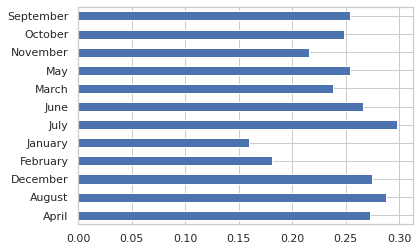

In [63]:
print_unreliable_client_plot('arrival_date_month')

It's difficult to identify a consistent relationship between month and booking cancellations. The most frequent cancellations (~30%) occurred in July, August. The lowest number occurred in January (15% of cancellations).

### meal 

BB    35055
SC     4801
HB     3263
FB      134
Name: meal, dtype: int64

BB    8563
SC    1562
HB     799
FB      41
Name: meal, dtype: int64

BB    0.244273
SC    0.325349
HB    0.244867
FB    0.305970
Name: meal, dtype: float64

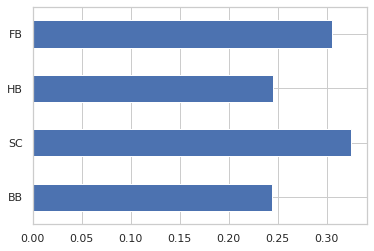

In [64]:
print_unreliable_client_plot('meal')

Among meal options, the highest cancellation rate is for SC and FB bookings (>30%). For other meal options, the cancellation rate is approximately 24%.

### distribution_channel

TA/TO        34637
Direct        5775
Corporate     2751
GDS             90
Name: distribution_channel, dtype: int64

TA/TO        9789
Direct        809
Corporate     350
GDS            17
Name: distribution_channel, dtype: int64

TA/TO        0.282617
Direct       0.140087
Corporate    0.127226
GDS          0.188889
Name: distribution_channel, dtype: float64

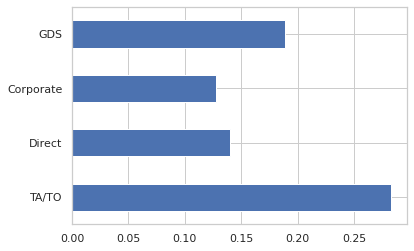

In [65]:
print_unreliable_client_plot('distribution_channel')

28% of cancellations occurred among orders whose distribution channel was marked TA/TO. For other channels, the cancellation rate was much lower, 13-19%

### reserved_room_type

A    30014
D     8412
E     2247
F     1176
B      599
G      578
C      227
Name: reserved_room_type, dtype: int64

A    7322
D    2408
E     503
F     337
G     179
B     173
C      43
Name: reserved_room_type, dtype: int64

A    0.243953
B    0.288815
C    0.189427
D    0.286258
E    0.223854
F    0.286565
G    0.309689
Name: reserved_room_type, dtype: float64

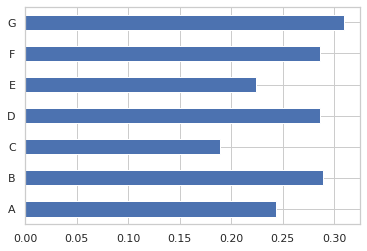

In [66]:
print_unreliable_client_plot('reserved_room_type')

In almost 31% of cases, reservations for class G rooms were cancelled.

### customer_type

Transient          35173
Transient-Party     5952
Contract            1872
Group                256
Name: customer_type, dtype: int64

Transient          9556
Transient-Party    1020
Contract            370
Group                19
Name: customer_type, dtype: int64

Transient          0.271686
Transient-Party    0.171371
Contract           0.197650
Group              0.074219
Name: customer_type, dtype: float64

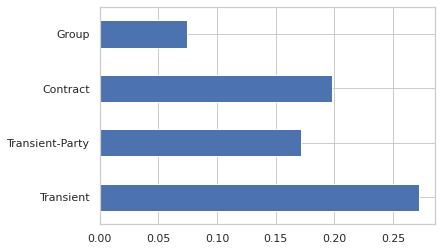

In [67]:
print_unreliable_client_plot('customer_type')

In 27% of cases, clients in the Transient category cancelled their reservations.

### is_repeated_guest

0    41812
1     1441
Name: is_repeated_guest, dtype: int64

0    10794
1      171
Name: is_repeated_guest, dtype: int64

0    0.258156
1    0.118668
Name: is_repeated_guest, dtype: float64

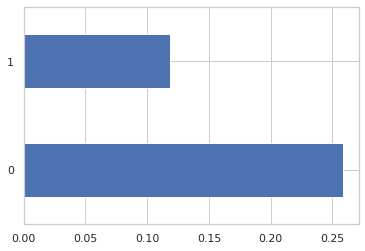

In [68]:
print_unreliable_client_plot('is_repeated_guest')

New customers cancelled their bookings more often, in 26% of cases.

### Conclusion: Portrait of an "unreliable" client

As a result of studying certain characteristics on a training sample, the following portrait of an "unreliable" client was compiled:

1. The client books a room with FB or SC meals.
3. The distribution channel is TA/TO.
4. The client books a category G room.
5. This client is a Transient client.
6. This client is a new client.

## General conclusion

Client: Hotel chain. Task: Develop a system for predicting room cancellations.

The work was divided into the following steps:
1. Client data was analyzed and prepared.
2. Various machine learning models were trained. The random forest-based model was deemed the most successful. Precision was chosen as the control metric. It indicates the proportion of true positive model responses among all model responses. The following metric values were obtained:
    * Precision metric value during cross-validation training: 0.308
    * Precision metric value on the test set: 0.448
3. The profit from implementing the ML model together with the deposit system was calculated:
    * Implementing deposits and an ML model that predicts room cancellations increases profit by 6,345,608.0, or 21.8%.
    * The profit increase is 16 times greater than the model development budget. The development budget is 400,000.
4. After exploratory data analysis, a profile of an "unreliable" client was created:
    * The client books a room with full board or standard meals.
    * Distribution channel - TA/TO.
    * The client books a category G room.
    * This is a Transient client.
    * This is a new client.